# Freyberg Model PEST setup example
Herein, we will show users how to use pyEMU to setup a groundwater model for use in pest.  We will cover the following topics:
- setup pilot points as parameters, including 1st-order tikhonov regularization
- setup other model inputs as parameters
- setup simulated water levels as observations
- setup simulated water budget components as observations (or forecasts)
- create a pest control file and adjust observation weights to balance the objective function

Note that, in addition to `pyemu`, this notebook relies on `flopy`. `flopy` can be obtained (along with installation instructions) at https://github.com/modflowpy/flopy.

In [1]:
%matplotlib inline
import os
import shutil
import platform
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle as rect
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", 
    message="ModflowDis.sr is deprecated. use Modflow.sr")
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
newparams = {'legend.fontsize':10, 'axes.labelsize':10,
             'xtick.labelsize':10, 'ytick.labelsize':10,
             'font.family':'Univers 57 Condensed', 
             'pdf.fonttype':42}
plt.rcParams.update(newparams)
import pyemu

flopy is installed in /Users/jwhite/Dev/flopy/flopy


## Model background
This example is based on the synthetic classroom model of Freyberg(1988).  The  model is a 2-dimensional MODFLOW model with 1 layer,  40 rows, and 20 columns.  The model has 2 stress periods: an initial steady-state stress period used for calibration, and a 5-year transient stress period.  The calibration period uses the recharge and well flux of Freyberg(1988); the last stress period use 25% less recharge and 25% more pumping to represent future conditions for a forecast period.

Freyberg, David L. "AN EXERCISE IN GROUND‐WATER MODEL CALIBRATION AND PREDICTION." Groundwater 26.3 (1988): 350-360.

In [2]:
#load the existing model and save it in a new dir and make sure it runs
import flopy
model_ws = os.path.join("Freyberg_transient")
ml = flopy.modflow.Modflow.load("freyberg.nam",model_ws=model_ws,verbose=False)
ml.exe_name = "mfnwt"
ml.model_ws = "temp"
EXE_DIR = os.path.join("..","bin")
if "window" in platform.platform().lower():
    EXE_DIR = os.path.join(EXE_DIR,"win")
elif "darwin" in platform.platform().lower():
    EXE_DIR = os.path.join(EXE_DIR,"win")
else:
    EXE_DIR = os.path.join(EXE_DIR,"linux")

[shutil.copy2(os.path.join(EXE_DIR,f),os.path.join("temp",f)) for f in os.listdir(EXE_DIR)]

ml.write_input()
ml.run_model()


changing model workspace...
   temp
FloPy is using the following  executable to run the model: /Users/jwhite/Dev/pyemu/bin/mac/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.3, 8/01/2017                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.04.0 09/15/2016                       

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/09/02 11:19:01

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     

 Solving:  Stress period:   102    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   103    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   104    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   105    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   106    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   107    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   108    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   109    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   110    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   111    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   112    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   113    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   114    Time step:     1    Groundwater-Flow Eqn.

 Solving:  Stress period:   231    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   232    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   233    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   234    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   235    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   236    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   237    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   238    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   239    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   240    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   241    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   242    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   243    Time step:     1    Groundwater-Flow Eqn.

 Solving:  Stress period:   342    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   343    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   344    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   345    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   346    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   347    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   348    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   349    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   350    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   351    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   352    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   353    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   354    Time step:     1    Groundwater-Flow Eqn.

(True, [])

# Observations
## HOB observations
Here we are going to setup an ``hob`` package to handle getting the observations from modflow.  Normally, you would already have this file made, but here we are just making one for fun

In [3]:
rc_df = pd.read_csv(os.path.join("freyberg","misc","obs_rowcol.dat"),delim_whitespace=True)
hds = flopy.utils.HeadFile(os.path.join(ml.model_ws,"freyberg.hds"))
data = hds.get_alldata()
obs = []
roff = 0.0#ml.dis.delc.array[0] / 2.0
coff = 0.0#ml.dis.delr.array[0] / 2.0
for n,r,c in zip(rc_df.name,rc_df.row,rc_df.col):
    name = "i{1:02d}j{2:02d}".format(n,r-1,c-1)
    d = np.zeros((data.shape[0]-1,2))
    d[:,0] = hds.times[1:]
    d[:,1] = data[1:,0,r-1,c-1] + np.random.randn(d.shape[0]) #add some random noise to the observations
    obs.append(flopy.modflow.HeadObservation(ml,obsname=name,layer=0,row=r-1,
                                  column=c-1,roff=roff,coff=coff,
                                  time_series_data=d))
flopy.modflow.ModflowHob(ml,obs_data=obs,iuhobsv=600)
ext_path = os.path.join(ml.model_ws,"ref")
if os.path.exists(ext_path):
    shutil.rmtree(ext_path)
print(ext_path)
os.mkdir(ext_path)
ml.external_path = os.path.split(ext_path)[-1]
ml.upw.hk.fmtin = "(FREE)"
ml.upw.sy.fmtin = "(FREE)"
ml.rch.rech.fmtin = "(FREE)"
ml.write_input()
ml.run_model()

temp/ref
Util2d:delr: resetting 'how' to external
Util2d:delc: resetting 'how' to external
Util2d:model_top: resetting 'how' to external
Util2d:botm_layer_0: resetting 'how' to external
Util2d:botm_layer_1: resetting 'how' to external
Util2d:botm_layer_2: resetting 'how' to external
Util2d:ibound_layer_0: resetting 'how' to external
Util2d:ibound_layer_1: resetting 'how' to external
Util2d:ibound_layer_2: resetting 'how' to external
Util2d:strt_layer_0: resetting 'how' to external
Util2d:strt_layer_1: resetting 'how' to external
Util2d:strt_layer_2: resetting 'how' to external
Util2d:rech_1: resetting 'how' to external
Util2d:rech_2: resetting 'how' to external
Util2d:rech_3: resetting 'how' to external
Util2d:rech_4: resetting 'how' to external
Util2d:rech_5: resetting 'how' to external
Util2d:rech_6: resetting 'how' to external
Util2d:rech_7: resetting 'how' to external
Util2d:rech_8: resetting 'how' to external
Util2d:rech_9: resetting 'how' to external
Util2d:rech_10: resetting 'ho

Util2d:rech_352: resetting 'how' to external
Util2d:rech_353: resetting 'how' to external
Util2d:rech_354: resetting 'how' to external
Util2d:rech_355: resetting 'how' to external
Util2d:rech_356: resetting 'how' to external
Util2d:rech_357: resetting 'how' to external
Util2d:rech_358: resetting 'how' to external
Util2d:rech_359: resetting 'how' to external
Util2d:rech_360: resetting 'how' to external
Util2d:rech_361: resetting 'how' to external
Util2d:rech_362: resetting 'how' to external
Util2d:rech_363: resetting 'how' to external
Util2d:rech_364: resetting 'how' to external
Util2d:rech_365: resetting 'how' to external
Util2d:hk: resetting 'how' to external
Util2d:vka: resetting 'how' to external
Util2d:ss: resetting 'how' to external
Util2d:sy: resetting 'how' to external
Util2d:hk: resetting 'how' to external
Util2d:vka: resetting 'how' to external
Util2d:ss: resetting 'how' to external
Util2d:sy: resetting 'how' to external
Util2d:hk: resetting 'how' to external
Util2d:vka: reset

 Solving:  Stress period:    88    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:    89    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:    90    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:    91    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:    92    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:    93    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:    94    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:    95    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:    96    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:    97    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:    98    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:    99    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   100    Time step:     1    Groundwater-Flow Eqn.

 Solving:  Stress period:   211    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   212    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   213    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   214    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   215    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   216    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   217    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   218    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   219    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   220    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   221    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   222    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   223    Time step:     1    Groundwater-Flow Eqn.

 Solving:  Stress period:   323    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   324    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   325    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   326    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   327    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   328    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   329    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   330    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   331    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   332    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   333    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   334    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:   335    Time step:     1    Groundwater-Flow Eqn.

(True, [])

``pyemu`` has a helper function to setup this instruction file for you and also load observations into dataframe

In [4]:
hob_df = pyemu.gw_utils.modflow_hob_to_instruction_file(os.path.join(ml.model_ws,ml.name+".hob.out"))

The dataframe returned has a lot of useful info that we will use later...


In [5]:
hob_df.head()

,simval,obsval,obsnme,ins_line,weight,obgnme
0,20.152809,18.006901,i03j10.1,l2 !i03j10.1!,1.0,obgnme
1,20.112955,20.760300,i03j10.2,l1 !i03j10.2!,1.0,obgnme
2,20.099697,19.853901,i03j10.3,l1 !i03j10.3!,1.0,obgnme
3,20.124004,21.135700,i03j10.4,l1 !i03j10.4!,1.0,obgnme
4,20.125566,21.897499,i03j10.5,l1 !i03j10.5!,1.0,obgnme


## list file budget components as observations (or forecasts)

Here we will use ``flopy`` and ``pyemu`` to load each of the flux and volume budget components from the ``modflow`` list file to use as observations (or forecasts).  These are valuable pieces of information and since observations are free, why not include them?  This helper function writes two instruction files: ``<flx_filename>.ins`` and ``<vol_filename>.ins``

In [6]:
# the flux budget output filename that will be written during each forward run
flx_filename=os.path.join(ml.model_ws,"flx.out")

# the volumne budget output filename that will be written during each forward run
vol_filename = os.path.join(ml.model_ws,"vol.out")
df_wb = pyemu.gw_utils.setup_mflist_budget_obs(os.path.join(ml.model_ws,ml.name+".list"))

In [7]:
df_wb.head()

,obsval,obsnme
flx_constant_head_19700102,-2446.3230,flx_constant_head_19700102
flx_constant_head_19700103,-2430.3396,flx_constant_head_19700103
flx_constant_head_19700104,-2369.6147,flx_constant_head_19700104
flx_constant_head_19700105,-2353.5742,flx_constant_head_19700105
flx_constant_head_19700106,-2417.2407,flx_constant_head_19700106


# Parameters

## pilot points

Here we will setup pilot points for several array-based ``modflow`` inputs using ``pyemu``


### setup pilot point locations

first specify what pilot point names we want to use for each model layer (counting from 0).  Here we will setup pilot points for ``hk``, ``sy`` and ``rech``.  The ``rech`` pilot points will be used as a single multiplier array for all stress periods to account for potential spatial bias in recharge.   

In [8]:
prefix_dict= {0:["hk1","sy1","rech1"]}


This helper function is doing a lot of things: writing templates, pilot point files, and creating a shapefile of pilot points.  The ``every_n_cell`` arg is key: it decides how many cells to skip between pilot point locations - since we passed the ``model``, only active model cells get pilot points (using ``bas6.ibound``).  Like many things with ``flopy``, the ``SpatialReference`` is used to define pilot point ``x`` and ``y `` coordinates

In [9]:
pp_cells = 3
pp_df = pyemu.pp_utils.setup_pilotpoints_grid(ml,prefix_dict=prefix_dict,every_n_cell=pp_cells,pp_dir=ml.model_ws,
                                           tpl_dir=ml.model_ws,shapename=os.path.join(ml.model_ws,"pp.shp"))

The ``dataframe`` return has the same info as the shapefile that was written - useful info, right?

In [10]:
pp_df.index = pp_df.parnme
pp_df

,name,x,y,zone,parval1,k,i,j,tpl,parnme,tpl_filename,pp_filename,pargp,partrans,parchglim,parlbnd,parubnd,scale,offset,dercom
parnme,,,,,,,,,,,,,,,,,,,,
hk100,pp_0000,620028.0,3352902.0,1.0,1.0,0,1,1,~ hk100 ~,hk100,temp/hk1pp.dat.tpl,temp/hk1pp.dat,hk1,log,factor,1.100000e-10,1.100000e+10,1.0,0.0,1
hk101,pp_0001,620778.0,3352902.0,1.0,1.0,0,1,4,~ hk101 ~,hk101,temp/hk1pp.dat.tpl,temp/hk1pp.dat,hk1,log,factor,1.100000e-10,1.100000e+10,1.0,0.0,1
hk102,pp_0002,621528.0,3352902.0,1.0,1.0,0,1,7,~ hk102 ~,hk102,temp/hk1pp.dat.tpl,temp/hk1pp.dat,hk1,log,factor,1.100000e-10,1.100000e+10,1.0,0.0,1
hk103,pp_0003,622278.0,3352902.0,1.0,1.0,0,1,10,~ hk103 ~,hk103,temp/hk1pp.dat.tpl,temp/hk1pp.dat,hk1,log,factor,1.100000e-10,1.100000e+10,1.0,0.0,1
hk104,pp_0004,623028.0,3352902.0,1.0,1.0,0,1,13,~ hk104 ~,hk104,temp/hk1pp.dat.tpl,temp/hk1pp.dat,hk1,log,factor,1.100000e-10,1.100000e+10,1.0,0.0,1
hk105,pp_0005,623778.0,3352902.0,1.0,1.0,0,1,16,~ hk105 ~,hk105,temp/hk1pp.dat.tpl,temp/hk1pp.dat,hk1,log,factor,1.100000e-10,1.100000e+10,1.0,0.0,1
hk106,pp_0006,620028.0,3352152.0,1.0,1.0,0,4,1,~ hk106 ~,hk106,temp/hk1pp.dat.tpl,temp/hk1pp.dat,hk1,log,factor,1.100000e-10,1.100000e+10,1.0,0.0,1
hk107,pp_0007,620778.0,3352152.0,1.0,1.0,0,4,4,~ hk107 ~,hk107,temp/hk1pp.dat.tpl,temp/hk1pp.dat,hk1,log,factor,1.100000e-10,1.100000e+10,1.0,0.0,1
hk108,pp_0008,621528.0,3352152.0,1.0,1.0,0,4,7,~ hk108 ~,hk108,temp/hk1pp.dat.tpl,temp/hk1pp.dat,hk1,log,factor,1.100000e-10,1.100000e+10,1.0,0.0,1


### geostats and kriging
now that we have pilot points setup, we need to solve the kriging equations for each model cell using pilot point locations.  Since we only have a single set of pilot points that we are reusing for several array-based ``modflow`` inputs, we only need to get the kriging factors once

In [11]:
hk_pp = pyemu.pp_utils.pp_file_to_dataframe(os.path.join(ml.model_ws,"hk1pp.dat"))

In [12]:
hk_pp.head()

,name,x,y,zone,parval1
0,pp_0000,620028.0,3352902.0,1,1.0
1,pp_0001,620778.0,3352902.0,1,1.0
2,pp_0002,621528.0,3352902.0,1,1.0
3,pp_0003,622278.0,3352902.0,1,1.0
4,pp_0004,623028.0,3352902.0,1,1.0


Let's setup a geostatistical structure.  The contribution doesn't matter for pilot point interpolation, but it does matter when we want to form a prior parameter covariance matrix - we will get to that later.  A good rule of thumb is to use an ``a`` value that is three times the pilot point spacing.  Also, since the all of these pilot points will be log transformed, we need to use a log-based geostatistical structure

findfont: Font family ['Univers 57 Condensed'] not found. Falling back to DejaVu Sans.


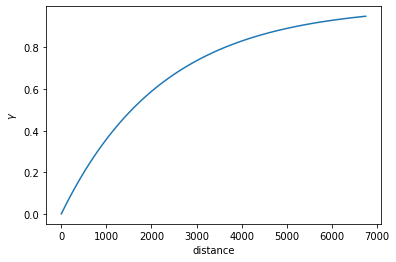

In [13]:
a = pp_cells * ml.dis.delr.array[0] * 3.0
v = pyemu.geostats.ExpVario(contribution=1.0,a=a)
gs = pyemu.geostats.GeoStruct(variograms=v,transform="log")
gs.plot()

This is where things get fun.  First we create an ``OrdinaryKrige`` object

In [14]:
ok = pyemu.geostats.OrdinaryKrige(geostruct=gs,point_data=hk_pp)

Now we use a helper function to solve the kriging factors for each active model cell: ``OrdinaryKrige.calc_factors_grid()`` includes all the standard kriging arguments, such as search radius, min and max interpolation points,zone_array, as well as the option to save the kriging variance array 

In [15]:
ok.calc_factors_grid(ml.sr, zone_array=ml.bas6.ibound[0].array,var_filename=os.path.join(ml.model_ws,"layer1_var.dat"))

starting interp point loop for 800 points
took 2.939659 seconds


,x,y,idist,inames,ifacts,err_var
0,619778.0,3353152.0,"[353.5533905932738, 1030.7764064044152, 1030.7764064044152, 1414.213562373095, 1767.766952966368...","[pp_0000, pp_0001, pp_0006, pp_0007, pp_0002, pp_0012, pp_0013, pp_0008, pp_0014, pp_0018, pp_00...","[0.823002631575806, 0.05335488181228149, 0.05346761473619846, -0.04881860409692692, 0.0226130580...",0.175981
1,620028.0,3353152.0,"[250.0, 790.5694150420949, 1000.0, 1250.0, 1520.690632574555, 1750.0, 1802.7756377319947, 1903.9...","[pp_0000, pp_0001, pp_0006, pp_0007, pp_0002, pp_0012, pp_0008, pp_0013, pp_0003, pp_0014, pp_00...","[0.8301077423154098, 0.1433540901080429, -0.010600340622018657, -0.03336003331533903, 0.02460691...",0.130918
2,620278.0,3353152.0,"[353.5533905932738, 559.0169943749474, 1030.7764064044152, 1118.033988749895, 1274.7548783981963...","[pp_0000, pp_0001, pp_0006, pp_0007, pp_0002, pp_0008, pp_0012, pp_0013, pp_0003, pp_0014, pp_00...","[0.6365049187960519, 0.3514543247189454, -0.018166606655800374, -0.020713894183918415, 0.0326469...",0.165700
3,620528.0,3353152.0,"[353.5533905932738, 559.0169943749474, 1030.7764064044152, 1030.7764064044152, 1118.033988749895...","[pp_0001, pp_0000, pp_0002, pp_0007, pp_0006, pp_0008, pp_0003, pp_0013, pp_0012, pp_0009, pp_00...","[0.5998492739405127, 0.37250067844602663, 0.05798773056610318, -0.02564208422231616, -0.01553997...",0.169331
4,620778.0,3353152.0,"[250.0, 790.5694150420949, 790.5694150420949, 1000.0, 1250.0, 1250.0, 1520.690632574555, 1750.0,...","[pp_0001, pp_0000, pp_0002, pp_0007, pp_0006, pp_0008, pp_0003, pp_0013, pp_0009, pp_0014, pp_00...","[0.7377795159435795, 0.16062901713768457, 0.14489600720282356, -0.038749181398756584, -0.0211389...",0.143273
5,621028.0,3353152.0,"[353.5533905932738, 559.0169943749474, 1030.7764064044152, 1030.7764064044152, 1118.033988749895...","[pp_0001, pp_0002, pp_0000, pp_0007, pp_0008, pp_0003, pp_0006, pp_0009, pp_0013, pp_0014, pp_00...","[0.5996284728403536, 0.351904086329679, 0.07113153965512457, -0.02540804091825155, -0.0175166862...",0.170042
6,621278.0,3353152.0,"[353.5533905932738, 559.0169943749474, 1030.7764064044152, 1030.7764064044152, 1118.033988749895...","[pp_0002, pp_0001, pp_0003, pp_0008, pp_0007, pp_0000, pp_0009, pp_0006, pp_0004, pp_0014, pp_00...","[0.6001289164692687, 0.35129598867854306, 0.05764399685533007, -0.023986578114407554, -0.0187197...",0.170703
7,621528.0,3353152.0,"[250.0, 790.5694150420949, 790.5694150420949, 1000.0, 1250.0, 1250.0, 1520.690632574555, 1520.69...","[pp_0002, pp_0001, pp_0003, pp_0008, pp_0007, pp_0009, pp_0000, pp_0004, pp_0014, pp_0006, pp_00...","[0.7381634529381041, 0.14422998966505501, 0.14469156815158551, -0.0373308302031888, -0.025042454...",0.144061
8,621778.0,3353152.0,"[353.5533905932738, 559.0169943749474, 1030.7764064044152, 1030.7764064044152, 1118.033988749895...","[pp_0002, pp_0003, pp_0001, pp_0008, pp_0009, pp_0004, pp_0007, pp_0010, pp_0000, pp_0014, pp_00...","[0.6000944537071662, 0.3517935920106162, 0.057108941235623184, -0.024123490493142316, -0.0174632...",0.170356
9,622028.0,3353152.0,"[353.5533905932738, 559.0169943749474, 1030.7764064044152, 1030.7764064044152, 1118.033988749895...","[pp_0003, pp_0002, pp_0004, pp_0009, pp_0008, pp_0001, pp_0010, pp_0007, pp_0015, pp_0005, pp_00...","[0.6001032346750941, 0.351785088203525, 0.05713296734457076, -0.023963744270043694, -0.017624563...",0.170353


Ok, we know that this function is slow for bigly models, but it is super convienent and allows a lot of flexibility.  So, once we have calculated the kriging factors for each active model cell, we need to write this to a factors file

In [16]:
ok.to_grid_factors_file(os.path.join(ml.model_ws,"pp.fac"))

Let's check out that kriging variance array....

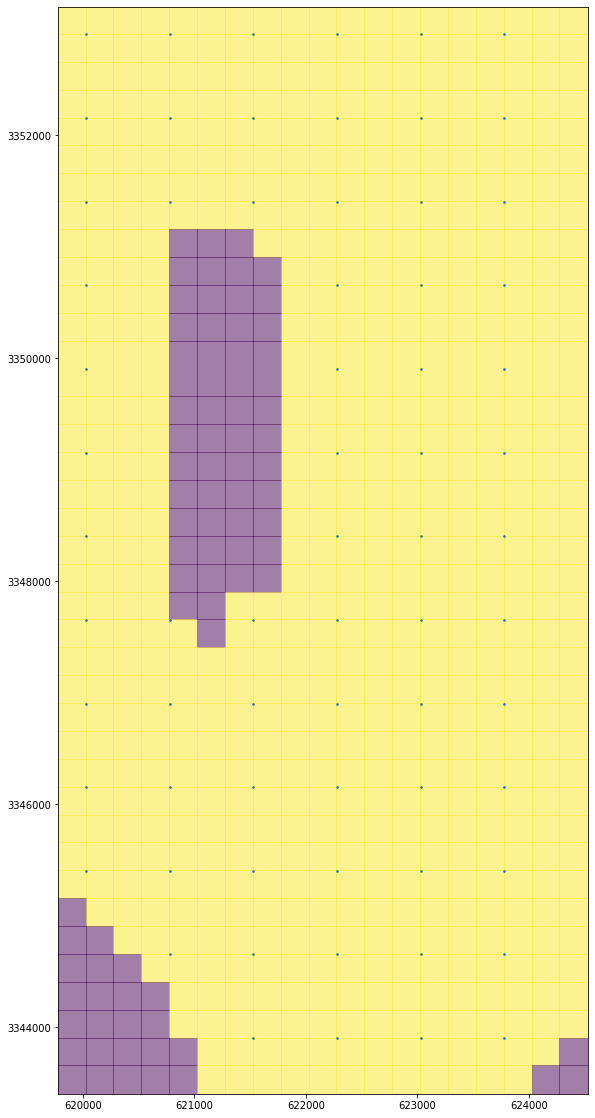

In [17]:
var_arr = np.ma.masked_invalid(np.loadtxt(os.path.join(ml.model_ws,"layer1_var.dat")))
fig = plt.figure(figsize=(20,20))
ax = plt.subplot(111,aspect="equal")
ax.pcolormesh(ml.sr.xcentergrid,ml.sr.ycentergrid,var_arr,alpha=0.5)
ax.scatter(hk_pp.x, hk_pp.y,marker='.',s=10)

In [18]:
ml.sr.xcentergrid[0,0],ml.sr.ycentergrid[0,0]

(619778.0, 3353152.0)

In [19]:
hk_pp.iloc[0,:].values

array(['pp_0000', 620028.0, 3352902.0, 1, 1.0], dtype=object)

## other inputs as parameters

Since we rarely know any model inputs perfectly, it is advisable to subject them to adjustment...not to get a good ``fit``, but so we can account for there contribution to uncertainty...How about the conductance between the surface water and groundwater systems.  In this model, we are using ``drain`` type boundaries.  So, let's setup a multiplier parameter for each ``drain`` cell's conductance.  

Since we told ``flopy`` to write external files, all of the list-type ``modflow`` inputs are also external, which makes this so much easier!  The first thing to do is copy the orginal drain list files (and all other files in the external directory) to a safe place:


In [20]:
ext_path = os.path.join(ml.model_ws,"ref")
ext_files = [f for f in os.listdir(ext_path)]
drain_files = [f for f in ext_files if "drn" in f.lower()]
#print(drain_files)
assert len(drain_files) == ml.nper,"{0},{1}".format(len(drain_files),ml.nper)
bak_path = os.path.join(ml.model_ws,"bak")
if os.path.exists(bak_path):
    shutil.rmtree(bak_path)
os.mkdir(bak_path)
for f in ext_files:
    shutil.copy2(os.path.join(ext_path,f),os.path.join(bak_path,f))
#assert len(os.listdir(bak_path)) == ml.nper

Now all we need to do is write a template file.  We will also write a generic cooresponding input file that will make testing easier later

In [21]:
drn_df = pd.read_csv(os.path.join(bak_path,drain_files[0]),
                     header=None,names=["l","r","c","stage","cond"],
                    delim_whitespace=True)
f_tpl = open(os.path.join(ml.model_ws,"drain_mlt.dat.tpl"),'w')
f_in = open(os.path.join(ml.model_ws,"drain_mlt.dat"),'w')
f_tpl.write("ptf ~\n")
#build parameter names from model cell info
drn_df.loc[:,"parnme"] = drn_df.apply(lambda x: "drn_i{1:02.0f}j{2:02.0f}".format(x.l-1,x.r-1,x.c-1),axis=1)
for parnme in drn_df.parnme:
    f_tpl.write("{0}  ~   {0}   ~\n".format(parnme))
    f_in.write("{0}     1.0\n".format(parnme))
f_tpl.close()
f_in.close()

# Building the pest control file...Finally!

Here we will use the template and instruction files to construct a control file.  Then we will use some ``pandas`` magic to set the appropriate parameter and observation info

In [22]:
tpl_files = [os.path.join(ml.model_ws,f) for f in os.listdir(ml.model_ws) if f.endswith(".tpl")]
input_files = [f.replace(".tpl",'') for f in tpl_files]
tpl_files

['temp/drain_mlt.dat.tpl',
 'temp/hk1pp.dat.tpl',
 'temp/sy1pp.dat.tpl',
 'temp/rech1pp.dat.tpl']

See why it is important to use a consistent naming structure for the templates-input file pairs?  Its the same for the instruction files

In [23]:
ins_files = [os.path.join(ml.model_ws,f) for f in os.listdir(ml.model_ws) if f.endswith(".ins")]
output_files = [f.replace(".ins",'') for f in ins_files]
ins_files

['temp/freyberg.hob.out.ins']

Now use these files to get a ``pyemu.Pst`` instance.  This object has lots of cool functionality...

In [24]:
pst = pyemu.Pst.from_io_files(tpl_files,input_files,ins_files,output_files)

Let's look at some of the important parts of the ``Pst`` class.  First, all attributes coorespond to the names in list in the pest manual.  For instance, the ``* parameter data`` section of the control file is a ``pandas.DataFrame`` attribute named ``parameter_data``:

In [25]:
pst.parameter_data.head()

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
drn_i00j14,drn_i00j14,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
drn_i01j14,drn_i01j14,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
drn_i02j14,drn_i02j14,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
drn_i03j14,drn_i03j14,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
drn_i04j14,drn_i04j14,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1


We see that the columns of the ``DataFrame`` follow the pest naming conventions.  Its the same for ``* observation data``:

In [26]:
pst.observation_data.head()

,obsnme,obsval,weight,obgnme
i03j10.1,i03j10.1,20.152809,1.0,obgnme
i03j10.10,i03j10.10,19.896666,1.0,obgnme
i03j10.100,i03j10.100,18.461061,1.0,obgnme
i03j10.101,i03j10.101,18.493416,1.0,obgnme
i03j10.102,i03j10.102,18.697491,1.0,obgnme


What ``pyemu`` has set as the ``obsval`` is the simulated equivalent, if it is available - in the ``pst_from_io_files()`` helper, ``pyemu`` tries to call ``inschek``, and, if successful, loads the output files from ``inschek``.  This can be very handy for error checking in the forward-run process. However, we still need to get the actual observed data into ``obsval``...remember that dataframe from hob processing?

In [27]:
hob_df.head()

,simval,obsval,obsnme,ins_line,weight,obgnme
0,20.152809,18.006901,i03j10.1,l2 !i03j10.1!,1.0,obgnme
1,20.112955,20.760300,i03j10.2,l1 !i03j10.2!,1.0,obgnme
2,20.099697,19.853901,i03j10.3,l1 !i03j10.3!,1.0,obgnme
3,20.124004,21.135700,i03j10.4,l1 !i03j10.4!,1.0,obgnme
4,20.125566,21.897499,i03j10.5,l1 !i03j10.5!,1.0,obgnme


Notice the ``obsval`` column?  Let's just set the index of this dataframe to ``obsnme``, then pandas does the hard work for us:

In [28]:
hob_df.index = hob_df.obsnme
hob_df.head()

,simval,obsval,obsnme,ins_line,weight,obgnme
obsnme,,,,,,
i03j10.1,20.152809,18.006901,i03j10.1,l2 !i03j10.1!,1.0,obgnme
i03j10.2,20.112955,20.760300,i03j10.2,l1 !i03j10.2!,1.0,obgnme
i03j10.3,20.099697,19.853901,i03j10.3,l1 !i03j10.3!,1.0,obgnme
i03j10.4,20.124004,21.135700,i03j10.4,l1 !i03j10.4!,1.0,obgnme
i03j10.5,20.125566,21.897499,i03j10.5,l1 !i03j10.5!,1.0,obgnme


In [29]:
pst.observation_data.loc[hob_df.index,"obsval"] = hob_df.obsval
pst.observation_data.loc[hob_df.index,:].head()

,obsnme,obsval,weight,obgnme
obsnme,,,,
i03j10.1,i03j10.1,18.006901,1.0,obgnme
i03j10.2,i03j10.2,20.760300,1.0,obgnme
i03j10.3,i03j10.3,19.853901,1.0,obgnme
i03j10.4,i03j10.4,21.135700,1.0,obgnme
i03j10.5,i03j10.5,21.897499,1.0,obgnme


BOOM!  that was easy...trying doing that without pandas....not fun!

We still have a few more items to set to specific values. The biggest one is initial values for parameters - they are given default values of 1.0:

In [30]:
pst.parameter_data.head()

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
drn_i00j14,drn_i00j14,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
drn_i01j14,drn_i01j14,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
drn_i02j14,drn_i02j14,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
drn_i03j14,drn_i03j14,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
drn_i04j14,drn_i04j14,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1


Luckily, ``pandas`` makes this very easy.  For example, let's set the ``DRN`` conductance parameters to have initial values of mean of the values in the model currently:


In [31]:
avg = ml.drn.stress_period_data[0]["cond"].mean()
par = pst.parameter_data #just a pointer to the full, long-named attribute
drn_pars = par.loc[par.parnme.apply(lambda x: x.startswith("drn")),"parnme"].values
par.loc[drn_pars,"parval1"] = avg
#set the par group to mean something
par.loc[drn_pars,"pargp"] = "drn_cond"
par.loc[drn_pars,"parubnd"] = avg * 10.0
par.loc[drn_pars,"parlbnd"] = avg * 0.1

Let's set the ``pargp`` for the remaining parameters using that cool pilot point dataframe from eariler...

In [32]:
par.loc[pp_df.parnme,"pargp"] = pp_df.pargp

We need to reset the model run command:

In [33]:
pst.model_command

['model.bat']

that is just a generic command. I prefer to use python scripts for this:

In [34]:
pst.model_command = ["python forward_run.py"]

Let's save this version of the control file

In [35]:
pst.write(os.path.join(ml.model_ws,"pest.pst"))

noptmax:30, npar_adj:241, nnz_obs:4368


But this means we need to write ``forward_run.py`` and it needs to perform several actions:
- apply kriging factors (using ``pyemu.gw_utils.fac2real()``)
- apply the drain multipliers
- call ``MODFLOW``
- process the ``MODFLOW`` list file

Lucky for you, I already made this file....

In [36]:
shutil.copy2(os.path.join("Freyberg_transient","forward_run.py"),os.path.join(ml.model_ws,"forward_run.py"))

'temp/forward_run.py'

### adding prior information

``pyemu`` supports both zero-order (preferred value) and first-order (preferred difference) Tikhonov regularization.  Let's set preferred value for the conductance parameters:

In [37]:
pyemu.utils.helpers.zero_order_tikhonov(pst,par_groups=["drn_cond"])
pst.prior_information.head()

,pilbl,equation,obgnme,weight
pilbl,,,,
drn_i00j14,drn_i00j14,1.0 * log(drn_i00j14) = 3.808800E+00,reguldrn_con,0.5
drn_i01j14,drn_i01j14,1.0 * log(drn_i01j14) = 3.808800E+00,reguldrn_con,0.5
drn_i02j14,drn_i02j14,1.0 * log(drn_i02j14) = 3.808800E+00,reguldrn_con,0.5
drn_i03j14,drn_i03j14,1.0 * log(drn_i03j14) = 3.808800E+00,reguldrn_con,0.5
drn_i04j14,drn_i04j14,1.0 * log(drn_i04j14) = 3.808800E+00,reguldrn_con,0.5


Now, let's set preferred difference equations for pilot point groups.  We will use the Pearson coef as the weight...

In [38]:
pp_groups = pp_df.groupby("pargp").groups
for pargp,par_names in pp_groups.items():
    this_pp_df = pp_df.loc[par_names,:]
    cov = gs.covariance_matrix(this_pp_df.x,this_pp_df.y,this_pp_df.parnme)
    pyemu.helpers.first_order_pearson_tikhonov(pst,cov,reset=False,abs_drop_tol=0.2)

getting CC matrix
processing
getting CC matrix
processing
getting CC matrix
processing


In [39]:
pst.prior_information

,pilbl,equation,obgnme,weight
pilbl,,,,
drn_i00j14,drn_i00j14,1.0 * log(drn_i00j14) = 3.808800E+00,reguldrn_con,0.500000
drn_i01j14,drn_i01j14,1.0 * log(drn_i01j14) = 3.808800E+00,reguldrn_con,0.500000
drn_i02j14,drn_i02j14,1.0 * log(drn_i02j14) = 3.808800E+00,reguldrn_con,0.500000
drn_i03j14,drn_i03j14,1.0 * log(drn_i03j14) = 3.808800E+00,reguldrn_con,0.500000
drn_i04j14,drn_i04j14,1.0 * log(drn_i04j14) = 3.808800E+00,reguldrn_con,0.500000
drn_i05j14,drn_i05j14,1.0 * log(drn_i05j14) = 3.808800E+00,reguldrn_con,0.500000
drn_i06j14,drn_i06j14,1.0 * log(drn_i06j14) = 3.808800E+00,reguldrn_con,0.500000
drn_i07j14,drn_i07j14,1.0 * log(drn_i07j14) = 3.808800E+00,reguldrn_con,0.500000
drn_i08j14,drn_i08j14,1.0 * log(drn_i08j14) = 3.808800E+00,reguldrn_con,0.500000


In [40]:
pst.control_data.pestmode = "regularization"

### setting PEST++ options

Some things I like to add:

In [41]:
pst.pestpp_options["svd_pack"] = "redsvd"
#pst.pestpp_options["forecasts"] = 

### saving the new control file

In [42]:
pst.write("freyberg_reg.pst")

noptmax:30, npar_adj:241, nnz_obs:4368


# Balancing the objective function